In [76]:
!pip install onnx
!pip install onnxruntime
!pip install onnx2pytorch
!pip install maraboupy
#!pip install tensorflow[and-cuda]==2.13.0

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [31]:

import onnx
from onnx2pytorch import ConvertModel


iris_onnx_path =  'iris_model_60.onnx'  # Adjust file extension if needed
PATTERN_PATH = 'relu_states'  

# Adjust file extension if needed
# onnx_model = onnx.load(iris_onnx_path)
# model = ConvertModel(onnx_model)
# data=iris.data
# data
# X_train
#labels=iris.target #target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10' - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n

In [32]:
from maraboupy import Marabou, MarabouCore, MarabouUtils
import json
from typing import Tuple, List
import logging
import pandas

def init_network():
  network = Marabou.read_onnx(iris_onnx_path)
  return network

EPSILON = 0.5
MAX_TIME = 300 #in seconds
M_OPTIONS: MarabouCore.Options = Marabou.createOptions(verbosity=0, numWorkers=10, timeoutInSeconds=MAX_TIME)

def convert_keys_to_int(x):
    if isinstance(x, dict):
        return {int(k) if k.isdigit() else k: convert_keys_to_int(v) for k, v in x.items()}
    return x

def parse_raw_idx(raw_idx: int) -> Tuple[int, int, int]:
    n_relus = 20
    offset = 7
    layer = raw_idx // n_relus
    idx = raw_idx % n_relus
    marabou_idx = 2*n_relus*layer + idx + offset
    return layer, idx, marabou_idx

with open(PATTERN_PATH, "r") as f:
  STABLE_PATTERNS = json.load(f)
  STABLE_PATTERNS=convert_keys_to_int(STABLE_PATTERNS)
loc = 0.5
radus = 0.5
non_restricted_dim = []

In [ ]:
for k,v in STABLE_PATTERNS.items():
  print(f'label={k}')
  for neuron,values in v.items():
    print(f"neuron={neuron}")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define the neural network architecture
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 20)  # Input layer to hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(20, 20) # Hidden layer to hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(20, 20) # Hidden layer to hidden layer
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(20, 3)  # Hidden layer to output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Initialize the network
model = IrisNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Check if the model trains without error up to this point
# "Model trained successfully!"


Epoch 10, Loss: 0.7110157608985901
Epoch 20, Loss: 0.4036754369735718
Epoch 30, Loss: 0.3703729510307312
Epoch 40, Loss: 0.14934490621089935
Epoch 50, Loss: 0.12423625588417053
Epoch 60, Loss: 0.005594757851213217
Epoch 70, Loss: 0.08966691792011261
Epoch 80, Loss: 0.002957663033157587
Epoch 90, Loss: 0.020865704864263535
Epoch 100, Loss: 0.08964332938194275


In [9]:
import onnx
from onnx2pytorch import ConvertModel


# onnx_model = onnx.load("iris_model.onnx")
# model = ConvertModel(onnx_model)

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

i=1
# Assuming the ReLU layers are named similarly to your PyTorch model, you can add hooks like this
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        # Register the hook
        layer.register_forward_hook(get_activation(f'relu{i}'))
        i=i+1

# Now, when you run a forward pass, the hooks will store the ReLU activations
with torch.no_grad():
    output = model(X_train_tensor[0].unsqueeze(0))

# Check the captured activations
activations
# Remove hooks (to clean up)
# hook1.remove()
# hook2.remove()

{'relu1': tensor([[1.2062, 1.4942, 0.0000, 2.6629, 0.0000, 0.0000, 0.1008, 0.0000, 1.2812,
          0.4878, 1.9803, 1.7296, 2.2217, 1.8856, 0.0000, 0.0000, 1.3994, 0.0000,
          0.0000, 2.1766]]),
 'relu2': tensor([[3.5583e+00, 0.0000e+00, 4.5825e+00, 0.0000e+00, 3.0476e+00, 3.5773e+00,
          0.0000e+00, 0.0000e+00, 3.5550e+00, 3.8430e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2207e+00, 3.7258e+00, 5.4662e+00,
          0.0000e+00, 1.4705e-03]]),
 'relu3': tensor([[ 0.0000,  0.0000,  0.0000,  2.0140,  0.0000,  3.8408,  0.0000,  0.0000,
           3.7716,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.4726,  8.1664,
           0.0000,  0.0000,  8.5828,  0.0000]])}

In [11]:
#accuracy:
i=0
with torch.no_grad():
  for inputs,label in zip(X_test_tensor, y_test_tensor):
          outputs = model(inputs.unsqueeze(0))
          #print(outputs)
          pred=outputs.argmax() #output not normalized
          if pred==label:
            i=i+1
print(f'{i}/{len(X_test_tensor)}')

model(X_train_tensor[0].unsqueeze(0))

onnx_file_path = "iris_model_60.onnx"
torch.onnx.export(model, torch.randn(1, 4), onnx_file_path, verbose=False)

30/30


find states:

In [29]:
states={}
for i in range(3):
  states[i]={}

with torch.no_grad():
  for neuron in range(60):
    for idx, (inputs, labels) in enumerate(train_loader):
      for i,t in zip(inputs,labels):
        t=t.item()
        outputs = model(i.unsqueeze(0))
        out=activations[f'relu{(neuron//20)+1}'][:,neuron%20].tolist()[0]
        if not neuron in states[t]:
          states[t][neuron]=[]
        states[t][neuron].append(out)

with open("relu_states", "w") as fp:
  json.dump(states, fp)

states[0]

# states
# json
# label:{{neuron: states}, }

{0: [0.828767716884613,
  0.6903653144836426,
  0.6370339393615723,
  1.246646523475647,
  0.8410075306892395,
  1.0450611114501953,
  1.4888828992843628,
  0.0,
  0.7377094626426697,
  0.7998632788658142,
  1.1056742668151855,
  1.649401307106018,
  0.8751844167709351,
  0.7333645820617676,
  1.2010773420333862,
  1.5152419805526733,
  0.9550075531005859,
  1.0494059324264526,
  0.9167447090148926,
  0.5503205060958862,
  0.6676362156867981,
  1.1625556945800781,
  0.750876784324646,
  0.5013340711593628,
  1.1982731819152832,
  0.6580435037612915,
  0.7823510766029358,
  0.6723171472549438,
  0.8734093308448792,
  1.2464121580123901,
  0.6151769161224365,
  0.40757331252098083,
  1.0747358798980713,
  0.9137061238288879,
  0.9532325267791748,
  1.0205014944076538,
  1.2062480449676514,
  0.45926231145858765,
  0.8200780153274536,
  0.9129357933998108],
 1: [1.266777515411377,
  1.1708238124847412,
  1.143419861793518,
  1.1619681119918823,
  1.940536379814148,
  1.3608477115631104,
 

###### initialize marabou

In [ ]:
#start with all relu，删减直到不能verify？

In [ ]:
# network=init_network()
# network.outputVars #4,5,6
# network.inputVars #0,1,2,3
# network.reluList #(i+10) for i in range(7,37)
# network.numVars #47
# offset=7

In [25]:
STABLE_PATTERNS[0]

{0: [0.9129357933998108,
  0.9532325267791748,
  0.6676362156867981,
  0.6903653144836426,
  0.8410075306892395,
  1.0494059324264526,
  0.9137061238288879,
  0.45926231145858765,
  1.1056742668151855,
  0.9550075531005859,
  0.8734093308448792,
  0.6723171472549438,
  1.4888828992843628,
  1.1625556945800781,
  0.5503205060958862,
  0.6151769161224365,
  1.1982731819152832,
  0.828767716884613,
  0.750876784324646,
  0.7998632788658142,
  0.0,
  0.6580435037612915,
  0.7377094626426697,
  1.2010773420333862,
  1.2464121580123901,
  0.8751844167709351,
  1.0747358798980713,
  1.5152419805526733,
  1.2062480449676514,
  0.6370339393615723,
  1.649401307106018,
  1.246646523475647,
  0.7823510766029358,
  0.40757331252098083,
  1.0450611114501953,
  0.7333645820617676,
  0.5013340711593628,
  0.8200780153274536,
  0.9167447090148926,
  1.0205014944076538],
 1: [1.1909759044647217,
  1.4731836318969727,
  1.5156525373458862,
  1.652188777923584,
  0.929201602935791,
  1.940536379814148,
 

In [21]:
network = init_network()
label=2
other_label=1
label_states=STABLE_PATTERNS[label]
network = add_relu_constraints(network, label_states) #previously commented out??
offset = network.outputVars[0][0][0]
for i in range(4):
  network.setLowerBound(i, 0)
  network.setUpperBound(i, 1)

for neuron,values in label_states.items():
        layer, idx, marabou_idx = parse_raw_idx(neuron)
        #print(f'{neuron}: {values}')
        if values.count(0) == len(values): #len(X_train)*0.5:
            constraint = MarabouUtils.Equation(MarabouCore.Equation.LE)
            constraint.addAddend(1, marabou_idx)
            constraint.setScalar(-0.001)
        else:
            constraint = MarabouUtils.Equation(MarabouCore.Equation.GE)
            constraint.addAddend(1, marabou_idx)
            constraint.setScalar(0.001)
        network.addEquation(constraint)
        # import pdb;pdb.set_trace()

#add output constraint
constraint = MarabouUtils.Equation(MarabouCore.Equation.GE)
constraint.addAddend(1, other_label+offset)
constraint.addAddend(-1, label+offset)
constraint.setScalar(0.001)
network.addEquation(constraint)


#add additional bounds here
exit_code: str
exit_code, vals, stats = network.solve(options=M_OPTIONS)
len(network.equList)

unsat


104

In [22]:
def add_relu_constraints(network: Marabou.MarabouNetworkNNet, label_states)->Marabou.MarabouNetworkNNet:
    """
    Add stable relus constraints to the Marabou network
    """
    for neuron,values in label_states.items():
        layer, idx, marabou_idx = parse_raw_idx(neuron)
        #print(f'{neuron}: {values}')
        if values.count(0) > len(values)*0.5: #len(X_train)*0.5:  len(values)
            constraint = MarabouUtils.Equation(MarabouCore.Equation.LE)
            constraint.addAddend(1, marabou_idx)
            constraint.setScalar(-0.001)
        else:
            constraint = MarabouUtils.Equation(MarabouCore.Equation.GE)
            constraint.addAddend(1, marabou_idx)
            constraint.setScalar(0.001)
        network.addEquation(constraint)
        # import pdb;pdb.set_trace()

    return network



def check_pattern(label_states, label: int, other_label: int)->Tuple[str, int]: #relu_check_list: List[int], relu_val: List[int]
    """
    In ACAS, the prediction is the label with smallest value.
    So we check that label - other_label < 0 forall input
    by finding assignments for label - other_label >=0
    """
    print("--------CHECK PATTERN: output_{} is always less than output_{} ? --------".format(label, other_label))
    network = init_network()
    network = add_relu_constraints(network, label_states) #previously commented out??
    offset = network.outputVars[0][0][0]
    for i in range(4):
      network.setLowerBound(i, 0)
      network.setUpperBound(i, 1)
    #add output constraint
    constraint = MarabouUtils.Equation(MarabouCore.Equation.GE)
    constraint.addAddend(1, other_label+offset)
    constraint.addAddend(-1, label+offset)
    constraint.setScalar(0.001)
    network.addEquation(constraint)


    #add additional bounds here
    exit_code: str
    exit_code, vals, stats = network.solve(options=M_OPTIONS)

    running_time:int = stats.getTotalTimeInMicro()

    return exit_code, running_time

def main():
    res = [[-1.]*3 for i in range(3)]
    # print(res)
    for label in range(3):
        print(f"For label {label}, check if its stable RELU pattern guarantees the output")
        for other_label in range(3):#range(10):
            if other_label == int(label):
                continue
            # relu_check_list = STABLE_PATTERNS[label]["stable_idx"]
            # relu_val = STABLE_PATTERNS[label]["val"]
            exit_code, running_time = check_pattern(STABLE_PATTERNS[label], label=int(label), other_label = other_label)
            if exit_code=="sat":
                res[int(label)][other_label] = "SAT:{}".format(running_time/10**6)
                break
            elif exit_code=="unsat":
                res[int(label)][other_label] = "UNS:{}".format(running_time/10**6)

            else:
                res[int(label)][other_label] = exit_code

    res = pandas.DataFrame(res)
    print(res)

main()


For label 0, check if its stable RELU pattern guarantees the output
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
For label 1, check if its stable RELU pattern guarantees the output
--------CHECK PATTERN: output_1 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
unsat
For label 2, check if its stable RELU pattern guarantees the output
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
              0             1             2
0          -1.0   UNS:0.00186  UNS:0.000906
1  UNS:0.001954          -1.0  UNS:0.001634
2  UNS:0.001045  UNS:0.001034          -1.0


In [57]:

for label in range(3):
  relu_label=STABLE_PATTERNS[label].copy()
  print(type(relu_label))
  def func(relus):
    for other_label in range(3):
      exit_code, running_time = check_pattern(relus, label=int(label), other_label = other_label)
      if exit_code=="sat":
        return False
    return True

  flag=func(relu_label)
  while flag:
    popped_key=sorted(relu_label.keys())[-1]
    relu_label.pop(popped_key)
    print(f"popped neuron={popped_key}")
    print(type(relu_label))
    flag=func(relu_label)
  print(f"for label {label}: remaining neurons= {relu_label.keys()}")

<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
popped neuron=59
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
popped neuron=58
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
popped neuron=57
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0

unsat
popped neuron=20
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
popped neuron=19
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
popped neuron=18
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat
popped neuron=17
<class 'dict'>
--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------

unsat
--------CHECK PATTERN: output_1 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
unsat
popped neuron=42
<class 'dict'>
--------CHECK PATTERN: output_1 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
unsat
popped neuron=41
<class 'dict'>
--------CHECK PATTERN: output_1 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
unsat
popped neuron=40
<class 'dict'>
--------CHECK PATTERN: output_1 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
unsat
popped neuron=39
<class 'dict'>
--------

unsat
popped neuron=11
<class 'dict'>
--------CHECK PATTERN: output_1 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
unsat
popped neuron=10
<class 'dict'>
--------CHECK PATTERN: output_1 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_1 is always less than output_2 ? --------
sat
input 0 = 0.0411738121766786
input 1 = 0.26259771820785754
input 2 = 0.3552448865722231
input 3 = 1.0
output 0 = -3.468105789532308
output 1 = 1.7845909887205424
output 2 = 1.7855909887205432
for label 1: remaining neurons= dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
<class 'dict'>
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: outp

In [68]:
def func(relus):
    for other_label in range(3):
      exit_code, running_time = check_pattern(relus, label=int(label), other_label = other_label)
      if exit_code=="sat":
        return False
    return True

def scancoarsen(relu_label):
    keyss = relu_label.keys()
    nap = []
    relu_label_copy = relu_label.copy()
    for k in keyss:
        relu_label_copy.pop(k)
        if func(relu_label_copy):
            relu_label.pop(k)
            continue
        else:
            nap.append(k)
            relu_label_copy = relu_label.copy()
    return relu_label.keys()
            
for label in range(3):
    relu_label=STABLE_PATTERNS[label].copy()
    scancoarsen(relu_label)

--------CHECK PATTERN: output_0 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_0 is always less than output_2 ? --------
unsat


RuntimeError: dictionary changed size during iteration

In [85]:
def func(relus):
    for other_label in range(3):
        exit_code, running_time = check_pattern(relus, label=int(label), other_label=other_label)
        if exit_code == "sat":
            return False
    return True

def scancoarsen(relu_label):
    keys = list(relu_label.keys())  # Convert keys to a list to avoid runtime error while modifying the dictionary
    for k in keys:
        print(f"consider neuron={k}")
        vals = relu_label[k]
        relu_label_copy = relu_label.copy()
        relu_label_copy.pop(k)
        if func(relu_label_copy):
            relu_label.pop(k)
            print(relu_label.keys())
            continue
        else:
            relu_label[k] = vals
    return list(relu_label.keys())  # Return the remaining keys

# # Assuming STABLE_PATTERNS is a list of dictionaries
# for label in range(1):
#     relu_label = STABLE_PATTERNS[label].copy()
#     remaining_keys = scancoarsen(relu_label)
#     print(f"Remaining keys after coarsening for label {label}: {remaining_keys}")

    
label = 2
relu_label = STABLE_PATTERNS[label].copy()
remaining_keys = scancoarsen(relu_label)
print(f"Remaining keys after coarsening for label {label}: {remaining_keys}")

consider neuron=0
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=1
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=2
---

unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=24
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=25
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([26, 27, 28, 2

unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=47
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=48
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat
dict_keys([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
consider neuron=49
--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than out

In [90]:
relu_label = STABLE_PATTERNS[label].copy()
res_dict = dict((k, relu_label[k]) for k in [54])
type(res_dict)
res_dict

func(res_dict)

--------CHECK PATTERN: output_2 is always less than output_0 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_1 ? --------
unsat
--------CHECK PATTERN: output_2 is always less than output_2 ? --------
unsat


True

#### relu_label = STABLE_PATTERNS[label].copy()
type(relu_label)

In [52]:
len(relu_label)

58

In [57]:
import numpy as np

def generate_samples(n, k, alpha, j):
    # Calculate the number of samples with the jth element equal to 1
    num_ones = int(alpha * n)
    
    # Generate n samples with the specified probability alpha
    samples = np.random.choice([0, 1], size=(n, k), p=[0.5, 0.5])
    print(samples)
    j_col = np.random.choice([0, 1], size=(n, 1), p=[1-alpha, alpha]).reshape(n,)
    print(j_col)
    samples[:,j] = j_col
    
    # Set the jth element to 1 in the required number of samples
    
    
    return samples

# Example usage:
n = 10  # Number of samples
k = 4   # Length of the list
alpha = 0.1  # Probability
j = 1   # Index of the element to be set to 1

generated_samples = generate_samples(n, k, alpha, j)
generated_samples

[[1 1 1 0]
 [1 0 0 1]
 [0 1 0 0]
 [0 1 1 0]
 [0 0 0 0]
 [1 0 0 1]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 1 1]]
[0 1 0 1 0 0 0 0 0 0]


array([[1, 0, 1, 0],
       [1, 1, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 1]])

In [48]:
generated_samples[:2, :]

array([[1, 0, 1, 1],
       [1, 0, 0, 1]])

In [22]:
relu_label=STABLE_PATTERNS[1].copy()
relu_label

NameError: name 'STABLE_PATTERNS' is not defined

In [16]:
import numpy as np
np.random(10)

TypeError: 'module' object is not callable



---



In [ ]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
          ('lin1', nn.Linear(2, 4)),
          ('relu1', nn.ReLU()),
          ('lin2', nn.Linear(4, 2)),
          ('relu2', nn.ReLU()),
          ('lin3', nn.Linear(2, 1)),
           ('sigmoid1',nn.Sigmoid())
          # ('relu3', nn.ReLU()) # this will make the gradient always zero for some initializations
        ]))

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lin1.weight tensor([[ 0.0055,  0.4843],
        [ 0.7000, -0.0224],
        [ 0.2257, -0.3779],
        [-0.3030, -0.6275]])
lin1.bias tensor([ 0.6780,  0.5154, -0.2446, -0.3855])
lin2.weight tensor([[ 0.2899,  0.1738, -0.3707, -0.0071],
        [ 0.1005,  0.4264,  0.0765, -0.0099]])
lin2.bias tensor([-0.2550, -0.1218])
lin3.weight tensor([[-0.3563, -0.6455]])
lin3.bias tensor([0.4740])


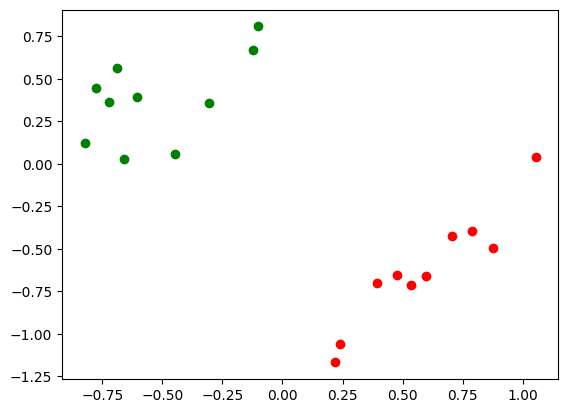

In [ ]:
X = np.array([[-0.60494626,  0.39463717],
       [-0.30378544,  0.35994518],
       [-0.10199207,  0.8077354 ],
       [-0.6891583 ,  0.56531763],
       [-0.82298213,  0.12062865],
       [-0.7219664 ,  0.36234102],
       [-0.7760751 ,  0.44770154],
       [-0.65878356,  0.02599421],
       [-0.44636518,  0.05483197],
       [-0.12357683,  0.67089474],
       [ 0.59597784, -0.6578017 ],
       [ 1.052702  ,  0.03756183],
       [ 0.8736961 , -0.4984176 ],
       [ 0.53515655, -0.71511005],
       [ 0.78909314, -0.39306254],
       [ 0.7054007 , -0.4269686 ],
       [ 0.47644103, -0.65322984],
       [ 0.24000564, -1.0623405 ],
       [ 0.39430314, -0.70325773],
       [ 0.21796265, -1.16941   ]], dtype=np.float32)



Y_ = [0 for i in range(10)] + [1 for i in range(10)]

Y = np.array(Y_, dtype=np.float32)
# show the plot
for i in range(len(X)):
    x,y = X[i]
    label = Y[i]
    if label > 0.5:
        plt.plot(x, y, 'ro')
    else:
        plt.plot(x, y, 'go')

In [ ]:
X_train = torch.from_numpy(X)
Y_train = torch.from_numpy(Y)
target = Y_train[:, None]
learning_rate = 0.3
params = list(model.parameters())
# criterion = nn.MSELoss()
criterion = nn.BCELoss()


for i in range(100):
    model.zero_grad()

    Y_tmp = model(X_train)
    loss = criterion(Y_tmp, target)
    print(f'i = {i}, loss = {loss}')

    loss.backward()

    # update the gradient
    for f in params:
        f.data.sub_(f.grad.data * learning_rate)

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach() > 0
    return hook

model.relu1.register_forward_hook(getActivation('relu1'))
model.relu2.register_forward_hook(getActivation('relu2'))

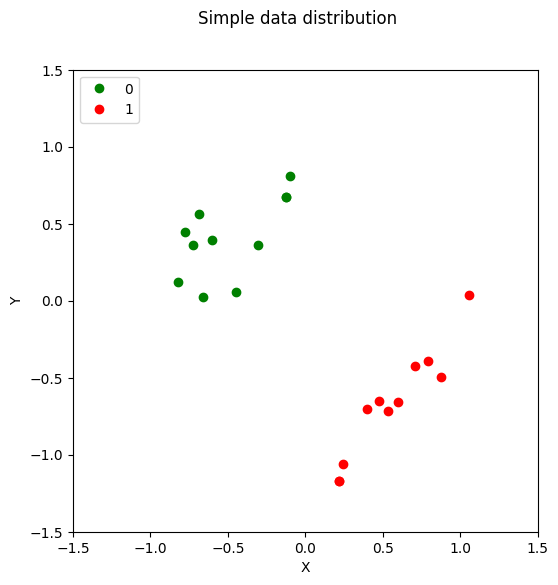

In [ ]:
Y_tmp = model(X_train)


fig = plt.figure(figsize=(6, 6))
for i in range(len(X)):
    x,y = X[i]
    pred = Y_tmp[i][0]
    if pred > 0.5:
        plt.plot(x, y, 'ro')
    else:
        plt.plot(x, y, 'go')

plt.plot(X[9][0], X[9][1], 'go', label="0")
plt.plot(X[-1][0], X[-1][1], 'ro', label="1")

fig.suptitle('Simple data distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc="upper left")
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.show()

In [ ]:
output = model(torch.from_numpy(X[0]))
activation['relu1'][0]

tensor(True)

In [ ]:
Refinement:
 For given area, find adversarial example. Refine that region.